# Greykite time series models

Time series models using Greykite

In [2]:
# Imports
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import plotly
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.autogen.forecast_config import EvaluationPeriodParam
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.utils.result_summary import summarize_grid_search_results
from collections import defaultdict

In [3]:
alaska = pd.read_csv(f'../data/alaska.csv')

In [4]:
alaska['week'] = pd.to_datetime(alaska['week'], format = '%Y-%m-%d')

In [4]:
alaska.head()

state       week  depression  anxiety  addiction  counselling  \
0  Alaska 2017-12-31          28       46         24           37   
1  Alaska 2018-01-07          37       45         25           65   
2  Alaska 2018-01-14          10       46         16           53   
3  Alaska 2018-01-21          33       41         10           35   
4  Alaska 2018-01-28          32       24          0           40   

   mental_health  stay_at_home  mask_mandate  gatherings_banned  \
0              0             0             0                  0   
1             37             0             0                  0   
2             30             0             0                  0   
3             14             0             0                  0   
4              0             0             0                  0   

   business_closures  travel_restrictions  
0                  0                    0  
1                  0                    0  
2                  0                    0  
3                  0                    0  
4                  0                    0

In [5]:
ts = UnivariateTimeSeries()
ts.load_data(
     df=alaska[['week', 'depression']],
     time_col="week",
     value_col="depression",
     freq="W-SUN")
print(ts.df.head())

                   ts   y
2017-12-31 2017-12-31  28
2018-01-07 2018-01-07  37
2018-01-14 2018-01-14  10
2018-01-21 2018-01-21  33
2018-01-28 2018-01-28  32


In [6]:
print(ts.describe_time_col())
print(ts.describe_value_col())

{'data_points': 262, 'mean_increment_secs': 604800.0, 'min_timestamp': Timestamp('2017-12-31 00:00:00'), 'max_timestamp': Timestamp('2023-01-01 00:00:00')}
count    262.000000
mean      35.412214
std       15.419980
min        0.000000
25%       25.000000
50%       35.000000
75%       44.750000
max       93.000000
Name: y, dtype: float64


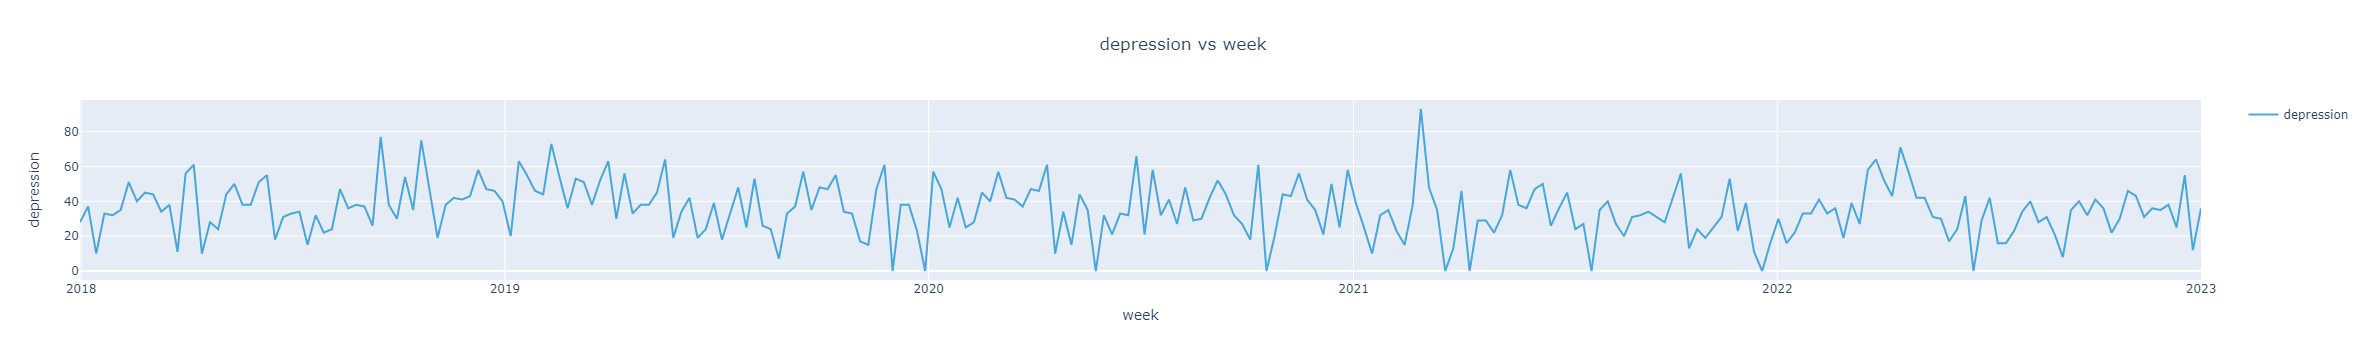

In [ ]:
fig = ts.plot()
plotly.io.show(fig)
#fig.write_html('../images/depression.html')
fig.write_image("../images/depression.jpeg")

In [ ]:
fig = ts.plot_quantiles_and_overlays(
     groupby_time_feature="month",
     show_mean=True,
     show_quantiles=False,
     show_overlays=True,
     center_values=True,
     overlay_label_time_feature="year",  # splits overlays by year
     overlay_style={"line": {"width": 1}, "opacity": 0.5},
     xlabel="Month",
     ylabel=ts.original_value_col,
     title="Monthly seasonality by year (centered)",
 )
fig.show("png")
fig.write_html('../images/Monthly seasonality by year.html')


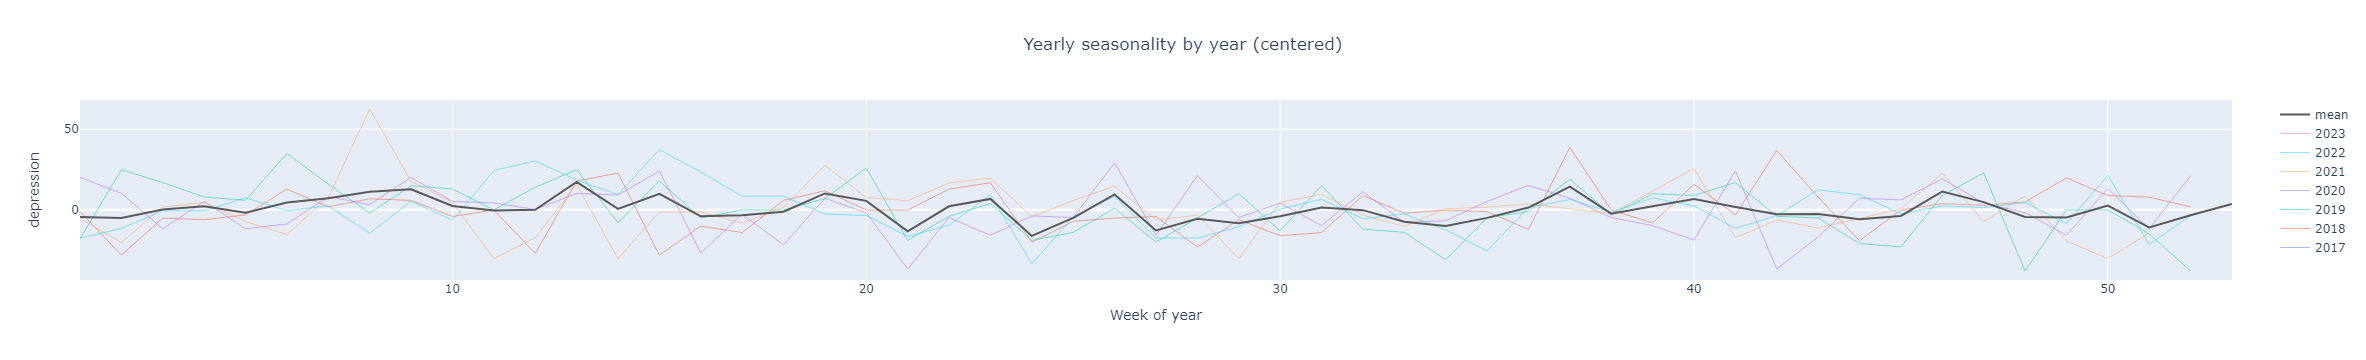

In [27]:
fig = ts.plot_quantiles_and_overlays(
     groupby_time_feature="woy",
     show_mean=True,
     show_quantiles=False,
     show_overlays=True,
     center_values=True,
     overlay_label_time_feature="year",  # splits overlays by year
     overlay_style={"line": {"width": 1}, "opacity": 0.5},
     xlabel="Week of year",
     ylabel=ts.original_value_col,
     title="Yearly seasonality by year (centered)",
 )
plotly.io.show(fig)

In [28]:
# specify dataset information
forecast_horizon = 4  # Forecast 4 weeks
time_col = 'ts'  # "ts"
value_col = 'y'  # "y"
metadata = MetadataParam(
     time_col=time_col,  # name of the time column ("date" in example above)
     value_col=value_col,  # name of the value column ("sessions" in example above)
     freq="W-SUN"  # "H" for hourly, "D" for daily, "W" for weekly, etc.
               # Any format accepted by `pandas.date_range`
 )

In [29]:
cv_min_train_periods = 52 * 2
 # Let CV use most recent splits for cross-validation.
cv_use_most_recent_splits = True
 # Determine the maximum number of validations.
cv_max_splits = 6
evaluation_period = EvaluationPeriodParam(
     test_horizon=forecast_horizon,
     cv_horizon=forecast_horizon,
     periods_between_train_test=0,
     cv_min_train_periods=cv_min_train_periods,
     cv_expanding_window=True,
     cv_use_most_recent_splits=cv_use_most_recent_splits,
     cv_periods_between_splits=None,
     cv_periods_between_train_test=0,
     cv_max_splits=cv_max_splits,
 )

In [30]:
def get_model_results_summary(result):
     """Generates model results summary.

     Parameters
     ----------
     result : `ForecastResult`
         See :class:`~greykite.framework.pipeline.pipeline.ForecastResult` for documentation.

     Returns
     -------
     Prints out model coefficients, cross-validation results, overall train/test evalautions.
     """
     # Get the useful fields from the forecast result
     model = result.model[-1]
     backtest = result.backtest
     grid_search = result.grid_search

     # Check model coefficients / variables
     # Get model summary with p-values
     print(model.summary())

     # Get cross-validation results
     cv_results = summarize_grid_search_results(
         grid_search=grid_search,
         decimals=2,
         cv_report_metrics=None,
         column_order=[
             "rank", "mean_test", "split_test", "mean_train", "split_train",
             "mean_fit_time", "mean_score_time", "params"])
     # Transposes to save space in the printed output
     print("================================= CV Results ==================================")
     print(cv_results.transpose())

     # Check historical evaluation metrics (on the historical training/test set).
     backtest_eval = defaultdict(list)
     for metric, value in backtest.train_evaluation.items():
         backtest_eval[metric].append(value)
         backtest_eval[metric].append(backtest.test_evaluation[metric])
     metrics = pd.DataFrame(backtest_eval, index=["train", "test"]).T
     print("=========================== Train/Test Evaluation =============================")
     print(metrics)

In [37]:
autoregression = None
extra_pred_cols = ["ct1", "ct_sqrt", "ct1:C(month, levels=list(range(1, 13)))"]

 # Specify the model parameters
model_components = ModelComponentsParam(
     autoregression=autoregression,
     seasonality={
         "yearly_seasonality": 25,
         "quarterly_seasonality": 0,
         "monthly_seasonality": 0,
         "weekly_seasonality": 0,
         "daily_seasonality": 0
     },
     changepoints={
         'changepoints_dict': {
             "method": "auto",
             "resample_freq": "7D",
             "regularization_strength": 0.5,
             "potential_changepoint_distance": "14D",
             "no_changepoint_distance_from_end": "60D",
             "yearly_seasonality_order": 25,
             "yearly_seasonality_change_freq": None,
         },
         "seasonality_changepoints_dict": None
     },
     events={
         "holiday_lookup_countries": []
     },
     growth={
         "growth_term": None
     },
     custom={
         'feature_sets_enabled': False,
         'fit_algorithm_dict': dict(fit_algorithm='ridge'),
         'extra_pred_cols': extra_pred_cols,
     }
 )

forecast_config = ForecastConfig(
     metadata_param=metadata,
     forecast_horizon=forecast_horizon,
     coverage=0.95,
     evaluation_period_param=evaluation_period,
     model_components_param=model_components
 )

 # Run the forecast model
forecaster = Forecaster()
result = forecaster.run_forecast_config(
     df=ts.df,
     config=forecast_config
 )

Fitting 6 folds for each of 1 candidates, totalling 6 fits


In [40]:
get_model_results_summary(result)

================================ Model Summary =================================

Number of observations: 262,   Number of features: 78
Method: Ridge regression
Number of nonzero features: 78
Regularization parameter: 174.3

Residuals:
         Min           1Q       Median           3Q          Max
      -35.14       -8.992       0.2225        8.695        55.35

           Pred_col Estimate Std. Err Pr(>)_boot sig. code               95%CI
          Intercept    37.46    1.772     <2e-16       ***      (33.92, 40.78)
                ct1  -0.4007   0.1509      0.006        ** (-0.6866, -0.08928)
ct1:C(mo... 13)))_2   0.1237   0.2536      0.682              (-0.2557, 0.673)
ct1:C(mo... 13)))_3   0.3042   0.2396      0.208             (-0.1432, 0.7612)
ct1:C(mo... 13)))_4   0.3452     0.27      0.194             (-0.2016, 0.8863)
ct1:C(mo... 13)))_5 -0.07871   0.1584      0.654             (-0.3923, 0.2167)
ct1:C(mo... 13)))_6  -0.1123   0.1935      0.552             (-0.5094, 0.2594)
c

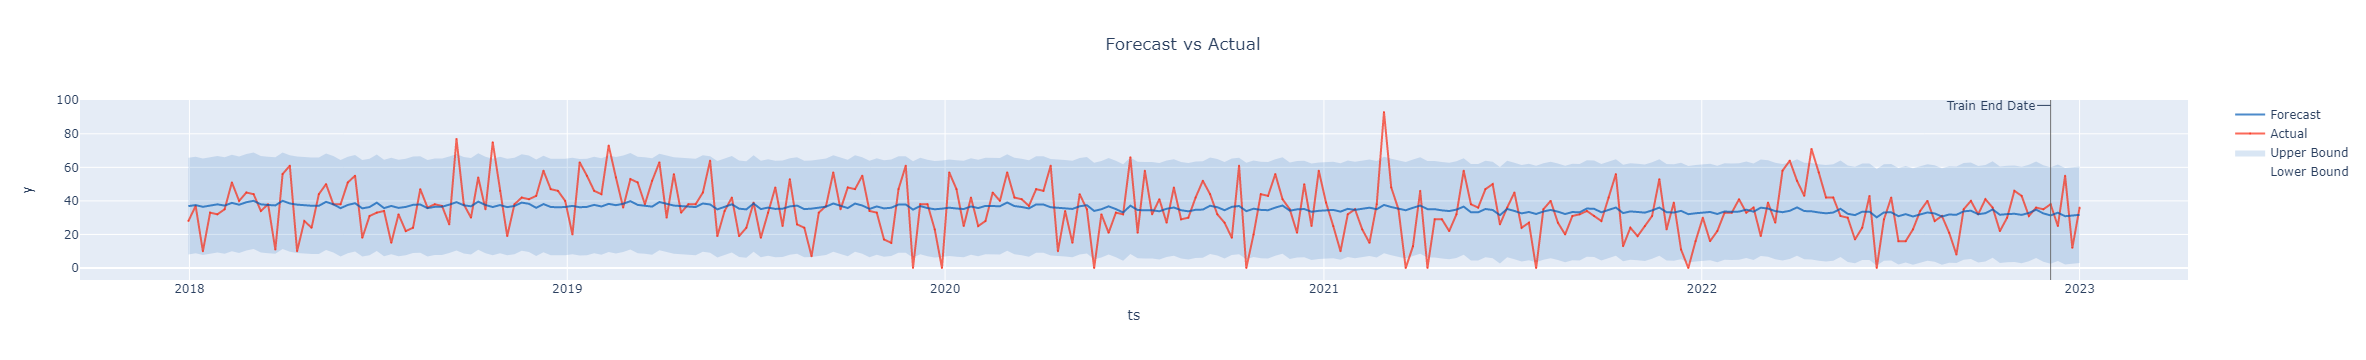

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [41]:
fig = result.backtest.plot()
plotly.io.show(fig)
fig.show("svg")

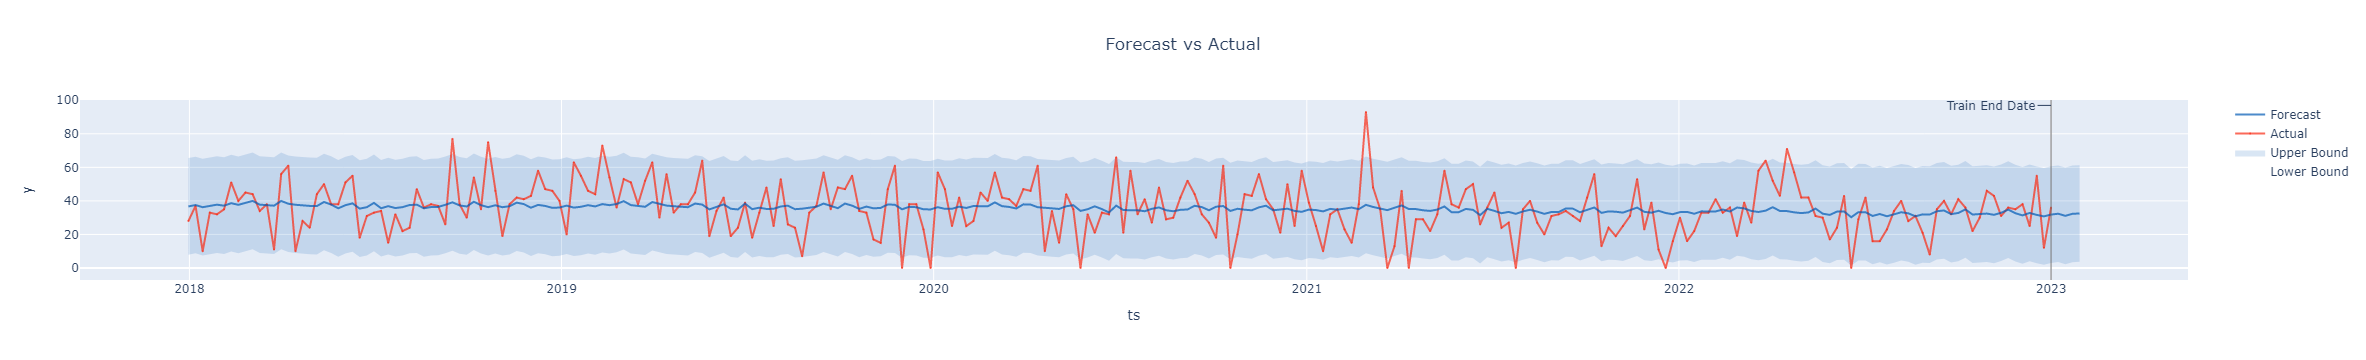

In [52]:
fig = result.forecast.plot()
plotly.io.show(fig)

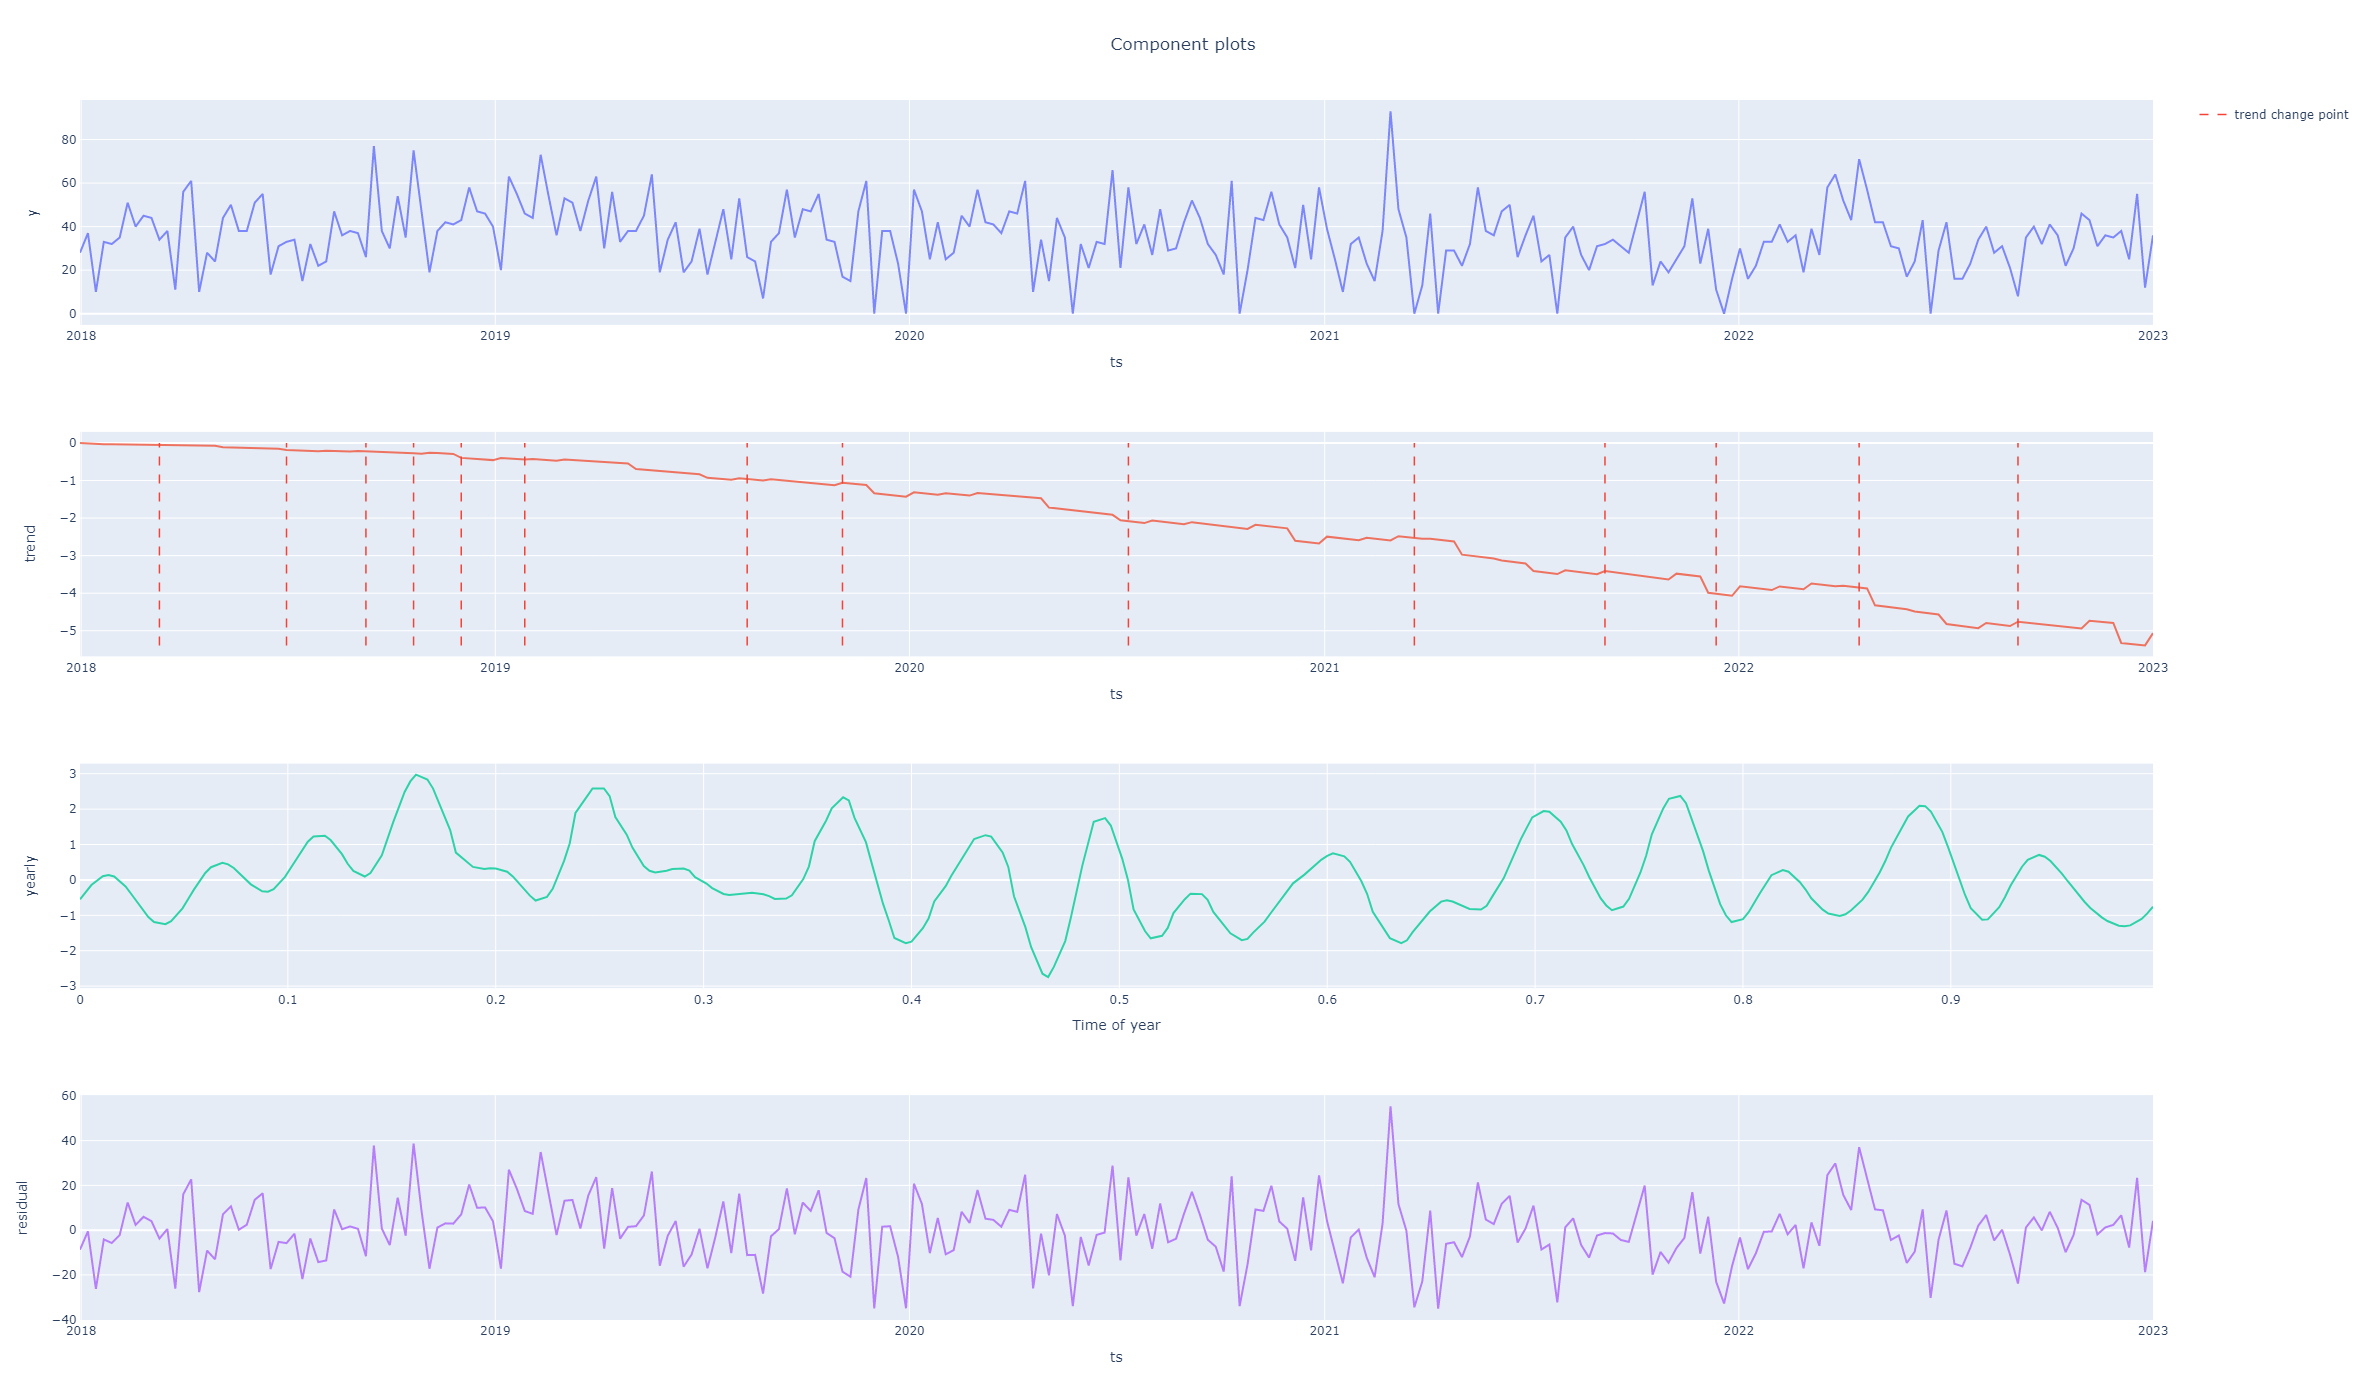

In [53]:
fig = result.forecast.plot_components()
plotly.io.show(fig)

In [54]:
autoregression = {
     "autoreg_dict": {
         "lag_dict": {"orders": [1]},  # Only use lag-1
         "agg_lag_dict": None
     }
 }
extra_pred_cols = ["ct1", "ct_sqrt", "ct1:C(month, levels=list(range(1, 13)))"]

 # Specify the model parameters
model_components = ModelComponentsParam(
     autoregression=autoregression,
     seasonality={
         "yearly_seasonality": 25,
         "quarterly_seasonality": 0,
         "monthly_seasonality": 0,
         "weekly_seasonality": 0,
         "daily_seasonality": 0
     },
     changepoints={
         'changepoints_dict': {
             "method": "auto",
             "resample_freq": "7D",
             "regularization_strength": 0.5,
             "potential_changepoint_distance": "14D",
             "no_changepoint_distance_from_end": "60D",
             "yearly_seasonality_order": 25,
             "yearly_seasonality_change_freq": None,
         },
         "seasonality_changepoints_dict": None
     },
     events={
         "holiday_lookup_countries": []
     },
     growth={
         "growth_term": None
     },
     custom={
         'feature_sets_enabled': False,
         'fit_algorithm_dict': dict(fit_algorithm='ridge'),
         'extra_pred_cols': extra_pred_cols,
     }
 )

forecast_config = ForecastConfig(
     metadata_param=metadata,
     forecast_horizon=forecast_horizon,
     coverage=0.95,
     evaluation_period_param=evaluation_period,
     model_components_param=model_components
 )

 # Run the forecast model
forecaster = Forecaster()
result = forecaster.run_forecast_config(
     df=ts.df,
     config=forecast_config
 )

Fitting 6 folds for each of 1 candidates, totalling 6 fits


C:\Users\ailin\anaconda3\envs\greykite\lib\site-packages\greykite\common\evaluation.py:418: UserWarning:

y_true contains 0. MAPE is undefined.

C:\Users\ailin\anaconda3\envs\greykite\lib\site-packages\greykite\common\evaluation.py:435: UserWarning:

y_true contains 0. MedAPE is undefined.

C:\Users\ailin\anaconda3\envs\greykite\lib\site-packages\greykite\common\evaluation.py:418: UserWarning:

y_true contains 0. MAPE is undefined.

C:\Users\ailin\anaconda3\envs\greykite\lib\site-packages\greykite\sklearn\sklearn_scorer.py:174: UserWarning:

Score is undefined for this split, setting to `np.nan`.

C:\Users\ailin\anaconda3\envs\greykite\lib\site-packages\greykite\common\evaluation.py:435: UserWarning:

y_true contains 0. MedAPE is undefined.

C:\Users\ailin\anaconda3\envs\greykite\lib\site-packages\greykite\sklearn\sklearn_scorer.py:174: UserWarning:

Score is undefined for this split, setting to `np.nan`.

C:\Users\ailin\anaconda3\envs\greykite\lib\site-packages\greykite\common\evaluat

In [55]:
get_model_results_summary(result)

================================ Model Summary =================================

Number of observations: 262,   Number of features: 79
Method: Ridge regression
Number of nonzero features: 79
Regularization parameter: 174.3

Residuals:
         Min           1Q       Median           3Q          Max
      -35.17       -9.013       0.2315        8.724        55.34

           Pred_col Estimate Std. Err Pr(>)_boot sig. code               95%CI
          Intercept    37.31    1.512     <2e-16       ***        (34.3, 39.9)
                ct1  -0.3992   0.1378      0.008        **  (-0.6511, -0.1328)
ct1:C(mo... 13)))_2   0.1237   0.2344      0.598              (-0.2965, 0.587)
ct1:C(mo... 13)))_3    0.303   0.2501      0.216             (-0.1962, 0.7902)
ct1:C(mo... 13)))_4   0.3439   0.2839      0.222             (-0.1924, 0.9202)
ct1:C(mo... 13)))_5  -0.0792   0.1708      0.652              (-0.409, 0.2406)
ct1:C(mo... 13)))_6  -0.1113   0.1976      0.586             (-0.5443, 0.2354)
c

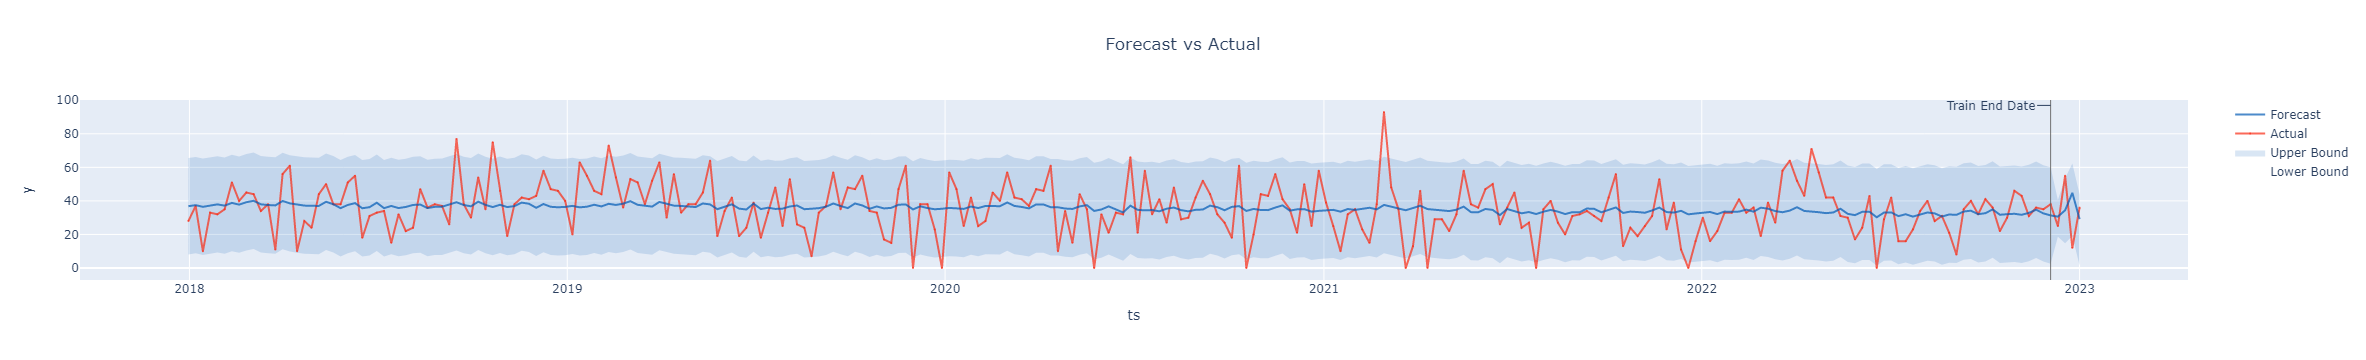

In [56]:
fig = result.backtest.plot()
plotly.io.show(fig)